# Import spatial data in AnnData and Squidpy
Tutorial by Hannah Spitzer and Giovanni Palla, Spatial Omics Data Analysis 2022.

*TL;DR we show how to store spatial data and large tissue images in AnnData and ImageContainer*

## Background

Spatial molecular data comes in many different formats, and to date there is no
one-size-fit-all solution for reading spatial data in Python.
Scanpy already provides a solution for Visium Spatial transcriptomics data with
the function `scanpy.read_visium` but that is basically it.
In Squidpy, we do provide some pre-processed (and pre-formatted) datasets,
with the module `squidpy.datasets` but it's not very useful for the users
who need to import their own data.

In this tutorial, we will showcase how spatial data are stored in `anndata.AnnData`.
We will use mock datasets for this purpose, yet showing with examples the important
details that you should take care of in order to exploit the full functionality of the
*AnnData-Scanpy-Squidpy* ecosystem.

For more information on data representation of spatial data, please also check out the [Squidpy tutorials](https://squidpy.readthedocs.io/en/stable/tutorials.html). This tutorial was adapted from [here](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_read_spatial.html) and [here](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_image_container.html).

In [1]:
%pip install scikit-image>0.19

from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
squidpy==1.2.2


Spatial coordinates in AnnData
------------------------------
First, let's generate some data. We will need:

  - an array of features (e.g. counts).
  - an array of spatial coordinates.
  - an image array (e.g. the tissue image).

In [2]:
rng = default_rng(42)
counts = rng.integers(0, 15, size=(10, 100))  # feature matrix
coordinates = rng.uniform(0, 10, size=(10, 2))  # spatial coordinates
image = rng.uniform(0, 1, size=(10, 10, 3))  # image

Let's first start with creating the :class:`anndata.AnnData` object.
We will first just use the count matrix and the spatial coordinates.
Specify the :attr:`anndata.AnnData.obsm` key as `'spatial'` is not strictly necessary
but will save you a lot of typing since it's the default for both Squidpy and Scanpy.

In [3]:
adata = AnnData(counts, obsm={"spatial": coordinates}, dtype=np.int64)

Next, let's run a standard Scanpy clustering and umap workflow.

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 10 × 100
    obs: 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the dummy cluster annotation ``adata.obs['leiden']`` in space.

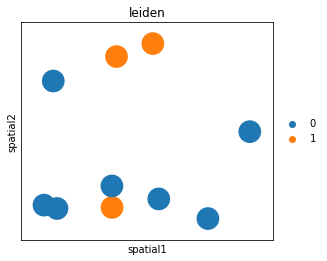

In [5]:
sc.pl.spatial(adata, color="leiden", spot_size=1)

Tissue image in AnnData
-----------------------
For use cases where there is no tissue image, this is all you need
to start using Scanpy/Squidpy for your analysis.
For instance, you can compute a spatial graph with `squidpy.gr.spatial_neighbors`
based on a fixed neighbor radius that is informative given your experimental settings.

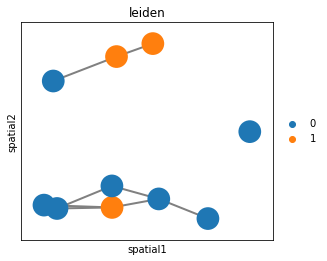

In [6]:
sq.gr.spatial_neighbors(adata, coord_type = "generic", radius=3.0)
sc.pl.spatial(adata, color="leiden", neighbors_key="spatial_neighbors", spot_size=1, edges=True, edges_width=2)

In case you do have an image of the tissue (or multiple, at different resolutions)
this is what you need to know to correctly store it in AnnData.
First, let's visualize the mock image from before.

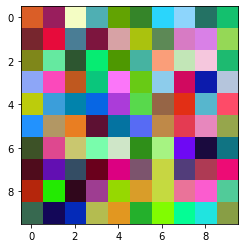

In [7]:
plt.imshow(image)

The image and its metadata are stored in the `uns` slot of `anndata.AnnData`.
Specifically, in the ``adata.uns['spatial'][<library_id>]`` slot, where `library_id`
is any unique key that refers to the tissue image.

For now, we will assume that there is only one image. This is the necessary metadata:

  - `tissue_hires_scalef` - this is the scale factor between the spatial coordinates
    units and the image pixels. In the case of Visium, this is usually ~0.17. In this case,
    we assume that the spatial coordinates are in the same scale of the pixels, and so
    we will set this value to 1.
  - `spot_diameter_fullres` - this is the diameter of the capture area for each observation.
    In the case of Visium, we usually call them `"spots"` and this value is set to ~89.

Here, we will set it to 0.5.

In [8]:
spatial_key = "spatial"
library_id = "tissue42"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": image}
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 0.5}

We don't provide the flexibility (yet) to change the values of such keys.
These are the keys provided by the Space Ranger output from 10x Genomics Visium
and therefore were the first to be adopted. In the future, we might settle to
a sightly different structure.
But for now, if all such key are correct, `squidpy.pl.spatial_scatter` works out of the box.

In [1]:
sq.pl.spatial_scatter(adata, color="leiden")

NameError: name 'sq' is not defined

You can fiddle around with the settings to see what changes.
For instance, let's change `tissue_hires_scalef` to half the previous value.

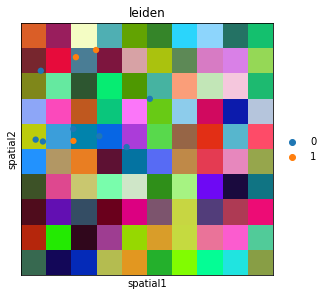

In [10]:
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 0.5, "spot_diameter_fullres": 0.5}
sq.pl.spatial_scatter(adata, color="leiden")

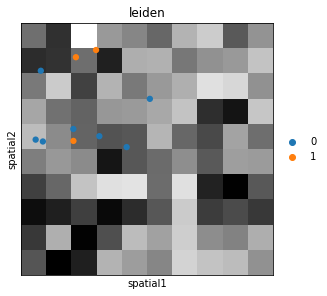

In [11]:
sq.pl.spatial_scatter(adata, color="leiden", img_cmap="gray")

As you can see, the spatial coordinates have been scaled down, and the image
was "zoomed in".

Of course, you might want to "analyze" such image. `squidpy.im.ImageContainer`
comes to the rescue! Just instantiate a new object and it will work out of the box.

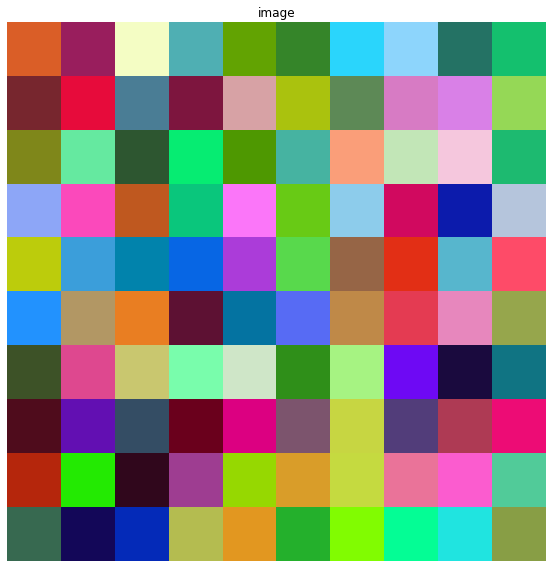

In [12]:
img = sq.im.ImageContainer(image)
img.show()

# ImageContainer object

The ImageContainer is the central object in Squidpy containing the high
resolution images. It wraps `xarray.Dataset` and provides different
cropping, processing, and feature extraction functions.

The `squidpy.im.ImageContainer` constructor can read in memory
`numpy.ndarray`/`xarray.DataArray` or on-disk image files. The
`ImageContainer` can store multiple image layers (for
example an image and a matching segmentation mask).

Images are expected to have at least a x and
y dimension, with optional channel and
z dimensions.

Most important arguments upon initialization are:

-   img - the image.
-   layer - the name of the image layer.
-   dims - to specify the dimensions names of
    img
-   lazy - set to True to allow lazy computations.
-   scale - set this to the scaling factor between the
    image and the coordinates saved.

In the example above, we just used the default values to initialise the ImageContainer.

In [13]:
img

ImageContainer[shape=(10, 10), layers=['image']]

As you can see, img contains one layer, called "image" of shape 10x10x1 with 3 channels.

Add layers to ImageContainer
============================

You can add image layers into the ImageContainer using
`squidpy.im.ImageContainer.add_img`.

The new layer has to share `x`, `y` and `z` dimensions with the already existing image. It can have
different channel dimensions. This is useful for add e.g., segmentation
masks.

By default, unique layer and channel dimension names are chosen, you can
specify them using the `layer` and `dims`
arguments.

In [15]:
arr_seg = np.zeros((10, 10))
arr_seg[4:6, 4:6] = 1

img.add_img(arr_seg, layer="seg1")
img

ImageContainer[shape=(10, 10), layers=['image', 'seg1']]

For convenience, you can also assign image layers directly using the new
layer name:

In [17]:
img["seg2"] = arr_seg
img

ImageContainer[shape=(10, 10), layers=['image', 'seg1', 'seg2']]

You can get a list of layers contained in an ImageContainer, and access
specific image-structured arrays using their names:

In [21]:
print(list(img))
img["image"]

['image', 'seg1', 'new-name']


<xarray.DataArray 'image' (y: 10, x: 10, z: 1, channels: 3)>
array([[[[0.85654802, 0.37226157, 0.1536129 ]],

        [[0.60084041, 0.11967256, 0.36491936]],

        [[0.95842918, 0.99546447, 0.77210489]],

        [[0.31096151, 0.68766505, 0.70540637]],

        [[0.3878417 , 0.64088863, 0.01072764]],

        [[0.20905766, 0.5250883 , 0.1637513 ]],

        [[0.16590687, 0.83630429, 0.989133  ]],

        [[0.55596943, 0.83906973, 0.99032166]],

        [[0.14159589, 0.44824561, 0.39257272]],

        [[0.08004928, 0.75533017, 0.43377903]]],

...

       [[[0.2163557 , 0.41402609, 0.31763563]],

        [[0.07810839, 0.02983477, 0.34647866]],

        [[0.01903415, 0.16548776, 0.72518332]],

        [[0.70809124, 0.73858039, 0.31715317]],

        [[0.89001946, 0.59383055, 0.12602634]],

        [[0.14371866, 0.69309543, 0.17294394]],

        [[0.5072927 , 0.99177448, 0.0040076 ]],

        [[0.0165798 , 0.99308458, 0.58463883]],

        [[0.12690998, 0.8973022 , 0.8803803 ]],

        [[0.53620041, 0.62179203, 0.27318719]]]])
Coordinates:
  * z        (z) <U1 '0'
Dimensions without coordinates: y, x, channels

Renaming of image layers is also possible using
`squidpy.im.ImageContainer.rename`:

In [20]:
img.rename("seg2", "new-name")
img

ImageContainer[shape=(10, 10), layers=['image', 'new-name', 'seg1']]

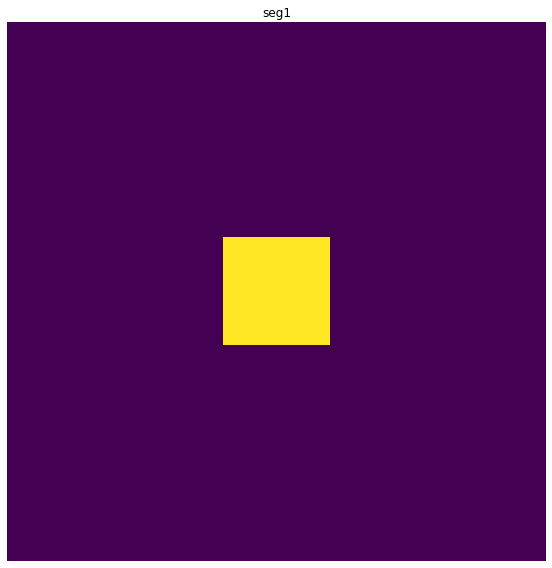

In [23]:
img.show('seg1')

## Processing images and extracting features

The main purpose of ImageContainer is to allow efficient image
processing, segmentation and features extraction with the functions `sq.im.process`, `sq.im.segment`, `sq.im.extract_features`.

These functions are build to be general and flexible. All of them allow
you to pass custom processing and feature extraction functions for easy
use of external packages with Squidpy.
In the following labs we will have a look at how to use them on real ST data.

For even more control, you can also use low-level functions provided by
`ImageContainer`:

 -   `sq.im.ImageContainer.apply` for custom processing functions that
     should be applied to a specific image layer.
 -   `sq.im.ImageContainner.feature_custom` for extracting features.

There are two generators, that allow you to iterate over a sequence of
image crops and apply processing functions to smaller crops (e.g. to
allow parallelization or processing images that won\'t fit in memory:

 -   `sq.im.ImageContainer.generate_equal_crops`, for evenly
     decomposing the image into equally sized crops.
 -   `sq.im.ImageContainer.generate_spot_crops`, for extracting image
     crops for each observation in the associated `adata`.

## Disclaimer
We are currently developing a new object for spatial data analysis in Python, which we'll address all limitations of current solutions with AnnData (described here and throughout the other tutorials). You can find a high level overview in this [talk](https://www.youtube.com/watch?v=d-h1aBK5ZH0). We aim to release an alpha version December 2022.